In [1]:
import numpy as np
from __future__ import division

In [152]:
%matplotlib inline
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl

filename = "CML_Recording_Both.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [153]:
spectrum.shape

(129, 11263)

In [257]:
import numpy as np

# divergence
def div(v,W,h):
    whv = np.dot(W,h) * 1/v
    div = whv - np.log(whv) - 1
    div = np.dot( div, np.ones(div.shape) )
    return div

# divergence gradient
def div_grad(v,W,h):
    grad = np.dot( 1/v - 1/(np.dot(W,h)) , W)
    return grad

# epsilon divergence
def compute_obj(v,W,h,eps):
    
    whv = (np.dot(W,h) + eps)/(v + eps)
    if any(whv < 0):
        print(W)
        print(h)
        print(v)
        print('whv: ' + str(whv))
    #print('whv.shape: ' + str(whv.shape))
    #print('np.dot(W,h): ' + str(np.dot(W,h)))
    div = whv - np.log(whv) - 1
    #print(div)
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    #print('compute_grad start')
    #print('W.shape: ' + str(W.shape))
    #print('h.shape: ' + str(h.shape))
    #print('v.shape: ' + str(v.shape))
    #print('np.dot(W,h).shape: ' + str( (np.dot(W,h) + eps).shape ) )
    #print((1/(v + eps) - 1/(np.dot(W,h) + eps)).shape)
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    #print('compute_grad end')
    return grad

def itakura_saito(y,x):
    y = np.array(y)
    x = np.array(x)
    return np.dot((y/x - np.log(y/x) -1) , np.ones(y.shape))
    
def get_h(eps,W,H, v):
    

    div = [0]* H.T.shape[0]
    for i, h in enumerate(H.T):
        div[i] = itakura_saito(eps+v, eps+np.dot(W,h))
    
    index = np.argmin(div)
    return np.array(H.T[index])

In [268]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[-1.69910175]
 [-1.71243841]]
[[-1.69909899]
 [-1.71243592]]


In [127]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
  
    beta = 0.5 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-4 # optimization precision
    n = 1e-1 #initial step size
    
    h = np.random.rand(2, 1)
    
    obj = [None]*max_iter
    
    max_backstep = 100 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        n = 1/beta*n # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - n * grad < 0)  and t < max_backstep ):
            t += 1
            n = beta * n
    
        new_obj = compute_obj(v,W,(h - n*grad),eps)
        while( new_obj > opt_prec * compute_obj(v,W,h,eps) and t < max_backstep):
            t += 1
            n = beta * n
            new_obj = abs(compute_obj(v,W,(h - n*grad),eps))
                      
        h = h - n * grad # update h according to gradient step
        k += 1 # update gradient step counter
       
   
    return h, obj[0:k]

h, obj = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)

[10.774082161014455, 4.0980561340699637, 0.80890403809538192]


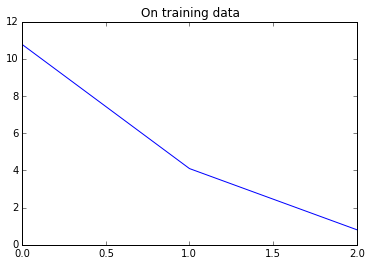

In [128]:
import matplotlib.pyplot as plt

index = [i for i in range(10)]
plt.title("On training data")
plt.plot([i for i in range(len(obj))], obj)

print(obj)

In [130]:
import random
def online_nmf(spectrum, W, H,A, B, rho, beta, n, eps):
   
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)

    t = 1
    W_old = W
    k = W.shape[1]
    h = np.random.rand(W.shape[1], 1)
    h_old = h
    while np.linalg.norm(W - W_old, ord = "fro") < n:
        
        t = t+1 
        
        ind = random.randint(0, len(spectrum.T))
        v = spectrum.T[ind]
        h_old = h
        h, obj = gradient_backtracking(v, W, h_old, 100, compute_grad, compute_obj, 1e-12)
   
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(np.dot(((eps+v)/(den**2)), h.T), np.dot(W.T,W))
        b += np.dot(1/den, h.T)
        
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            W = np.array([x/sum(x) for x in zip(*W)]).T
            A = np.array([x/sum(x) for x in zip(*A)]).T
            B = np.array([x*sum(x) for x in zip(*B)]).T
            
        if t > 30:
            print(W.shape)
            break

eps = 1e-12
v = spectrum.T[0]
K = 2
W = np.random.rand(spectrum.shape[0],K)
H = np.zeros((K, spectrum.shape[1]))

A = np.zeros(W.shape)
B = np.zeros(W.shape)


online_nmf(spectrum, W, H, A, B, 0.5, 100, 1e-3, eps)

(129, 2)


In [ ]:
eps = 1e-12
random.seed(12222015)

In [92]:
s = [sum(x) for x in zip(*W)]
W = [sum(x) for x in zip(*W)]

In [93]:
p.shape

(1, 129)

In [245]:
W = np.array([[1,1], [1,2], [2,2]])
X = [1,2]



In [246]:
W

array([[1, 1],
       [1, 2],
       [2, 2]])

In [237]:
X = W.T
for i in range(2):
    
    col_sum = X[i].sum()
    print(X[i]/col_sum)
    X[i] = (X[i]/col_sum)
    print(X[i])


[ 0.25  0.25  0.5 ]
[0 0 0]
[ 0.2  0.4  0.4]
[0 0 0]


In [251]:
z = np.array([x/sum(x) for x in zip(*W)])

In [252]:
z.T

array([[ 0.25,  0.2 ],
       [ 0.25,  0.4 ],
       [ 0.5 ,  0.4 ]])

In [ ]:
import numpy as np

# divergence
def div(v,W,h):
    whv = np.dot(W,h) * 1/v
    div = whv - np.log10(whv) - 1
    div = np.dot( div, np.ones )
    return div

# divergence gradient
def div_grad(v,W,h):
    grad = np.dot( 1/v - 1/(np.dot(W,h)) , W)
    return grad

# epsilon divergence
def eps_div(v,W,h,eps):
    whv = (np.dot(W,h) + eps) * 1/(v + eps)
    div = whv - np.log10(whv) - 1
    div = np.dot( div, np.ones )
    return div

# epsilon divergence gradient
def eps_div_grad(v,W,h,eps):
    grad = np.dot( 1/(v + eps) - 1/(np.dot(W,h) + eps), W)
    return grad